In [2]:
import numpy as np
import pandas as pd
import os
import yaml
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

# Load config

In [3]:
CONFIG_PATH = "configs/"

In [4]:
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

In [25]:
config = load_config("config.yaml")

In [27]:
config

{'dataset': {'train_img_path': 'dataset/train_v2',
  'test_img_path': 'dataset/test_v2',
  'train_lbl_path': 'dataset/train_ship_segmentations_v2.csv'},
 'original_img_size': 768,
 'new_img_size': 256}

In [18]:
config['dataset']['train_img_path']

'dataset/train_v2'

# Data read

In [7]:
train_ship_data = pd.read_csv("dataset/train_ship_segmentations_v2.csv")

# Data preview

In [8]:
train_ship_data.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [9]:
train_ship_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [38]:
train_ship_data.iloc[2]["EncodedPixels"].split(" ")

['264661',
 '17',
 '265429',
 '33',
 '266197',
 '33',
 '266965',
 '33',
 '267733',
 '33',
 '268501',
 '33',
 '269269',
 '33',
 '270037',
 '33',
 '270805',
 '33',
 '271573',
 '33',
 '272341',
 '33',
 '273109',
 '33',
 '273877',
 '33',
 '274645',
 '33',
 '275413',
 '33',
 '276181',
 '33',
 '276949',
 '33',
 '277716',
 '34',
 '278484',
 '34',
 '279252',
 '33',
 '280020',
 '33',
 '280788',
 '33',
 '281556',
 '33',
 '282324',
 '33',
 '283092',
 '33',
 '283860',
 '33',
 '284628',
 '33',
 '285396',
 '33',
 '286164',
 '33',
 '286932',
 '33',
 '287700',
 '33',
 '288468',
 '33',
 '289236',
 '33',
 '290004',
 '33',
 '290772',
 '33',
 '291540',
 '33',
 '292308',
 '33',
 '293076',
 '33',
 '293844',
 '33',
 '294612',
 '33',
 '295380',
 '33',
 '296148',
 '33',
 '296916',
 '33',
 '297684',
 '33',
 '298452',
 '33',
 '299220',
 '33',
 '299988',
 '33',
 '300756',
 '33',
 '301524',
 '33',
 '302292',
 '33',
 '303060',
 '33',
 '303827',
 '34',
 '304595',
 '34',
 '305363',
 '33',
 '306131',
 '33',
 '306899',

In [10]:
train_ship_data.iloc[2]["ImageId"]

'000155de5.jpg'

# Create mask

In [74]:
def Create_mask(labels, img_size):
    mask = np.zeros(img_size*img_size, np.float32)
    np_lbl = np.asarray(labels, dtype=int)
    pairs = []
    for i in range(0, len(np_lbl), 2):
        # Create a tuple of even and odd numbers
        start_ind = np_lbl[i]
        end_ind = np_lbl[i] + np_lbl[i + 1]
        mask[start_ind:end_ind] = 1.0

    return mask.reshape((img_size, img_size)).T

In [75]:
mask = Create_mask(train_ship_data.iloc[2]["EncodedPixels"].split(" "), config['original_img_size'])

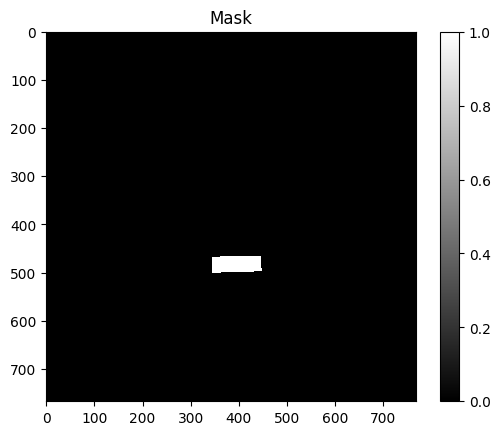

In [76]:
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title('Mask')
plt.colorbar()
plt.show()

# Image

In [19]:
image = cv2.imread(config['dataset']['train_img_path'] + "/" + train_ship_data.iloc[2]["ImageId"])

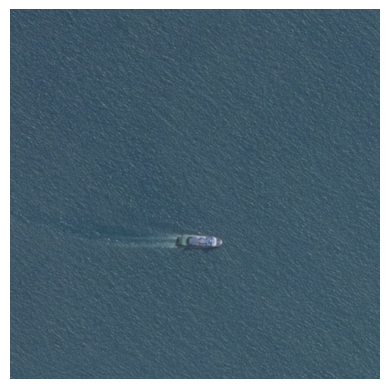

In [91]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
image = image / 127.5 - 1